In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [16]:
# constants
N_NODES = 500
N_EDGES = 3
seed = 1234
N_SIM = 100
N_FEATURES = 2
SHARE_TREATMENT = 0.5

MEAN_RANGE = (-10, 10)
STD_RANGE = (0.1, 5.0)
MEAN_ERROR_RANGE = (0.02, 0.3)
STD_ERROR_RANGE = (0.001, 0.1)
n_influence_list = list(np.arange(0, 1, 0.2))
treatment_effect = 0.3

In [17]:
def generate_random_mean_std(n_features, mean_range=MEAN_RANGE, std_range=STD_RANGE):
    means = np.random.uniform(mean_range[0], mean_range[1], n_features)
    stds = np.random.uniform(std_range[0], std_range[1], n_features)
    return means, stds

def generate_random_beta_matrix(n_features):
    means, stds = generate_random_mean_std(n_features)
    beta = np.random.normal(means, stds, n_features)
    return beta

def generate_random_data(n_nodes, n_features):
    means, stds = generate_random_mean_std(n_features)
    data = np.zeros((n_nodes, n_features))
    
    for i in range(n_features):
        data[:, i] = np.random.normal(means[i], stds[i], n_nodes)
        
    return data

def generate_random_error(n_nodes, mean_range=MEAN_ERROR_RANGE, std_range=STD_ERROR_RANGE):
    mean, std = generate_random_mean_std(n_features=1, mean_range=mean_range, std_range=std_range)
    error = np.random.normal(mean, std, n_nodes)

    return error

def get_group_data(n_nodes, share_treatment=0.5):
    n_treatment = int(n_nodes * share_treatment)
    n_control = n_nodes - n_treatment 
    group = np.array([1] * n_treatment + [0] * n_control)
    return group

In [18]:
def define_outcome_SAR(
    G,
    n_nodes,
    covariates,
    betas,
    epsilon,
    neighbour_influence,
    treatment_effect,
    row_normalized=False,
    group_data=0):
    adj_matrix = nx.to_numpy_array(G)
    if row_normalized:
        adj_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)
    I = np.eye(n_nodes)
    weight = scipy.linalg.inv(I - neighbour_influence*adj_matrix)
    if group_data is not None:
        y = weight@covariates@betas + weight@epsilon + weight@group_data*treatment_effect
    else:
        y = weight@covariates@betas + weight@epsilon

    return y

In [19]:
def get_param_pvalue_linreg(data, group_assignment, outcome):
    data_tr = np.column_stack((data, group_assignment))
    X = sm.add_constant(data_tr)
    model = sm.OLS(outcome, X)
    results = model.fit()

    # TODO: change for it not to be fix for cov number
    return results.params[3], results.pvalues[3]

In [26]:
def simulate_test(n_sim, n_nodes, n_edges, n_features, mean_range_cov, std_range_cov, mean_range_error, std_range_error, share_treatment, neighbour_influence, with_effect, treatment_effect, seed):
    outcome_dict = {i: [] for i in range(n_sim)}
    data_dict = {i: [] for i in range(n_sim)}
    betas_dict = {i: [] for i in range(n_sim)}
    group_assignments = []
    true_effects = []
    params = []
    pvalues = []

    for i in tqdm(range(n_sim)):
        G = nx.barabasi_albert_graph(n=n_nodes, m=n_edges, seed=seed)
        adj_matrix = nx.to_numpy_array(G)
        means, stds = generate_random_mean_std(n_features, mean_range=mean_range_cov, std_range=std_range_cov)
        betas = generate_random_beta_matrix(n_features)
        data = generate_random_data(n_nodes, n_features)
        error = generate_random_error(n_nodes, mean_range=mean_range_error, std_range=std_range_error)
        group_assignment = get_group_data(n_nodes, share_treatment)
        if with_effect:
            sim_treatment_effect = np.random.normal(treatment_effect, 0.09)
        else:
            sim_treatment_effect = treatment_effect
        outcome = define_outcome_SAR(
            G=G,
            n_nodes=n_nodes,
            covariates=data,
            betas=betas,
            epsilon=error,
            neighbour_influence=neighbour_influence,
            group_data=group_assignment,
            treatment_effect=treatment_effect
        )

        param, pvalue = get_param_pvalue_linreg(data=data, group_assignment=group_assignment, outcome=outcome)

        outcome_dict[i] = outcome
        data_dict[i] = data
        betas_dict[i] = betas
        group_assignments.append(group_assignment)
        true_effects.append(sim_treatment_effect)
        params.append(param)
        pvalues.append(pvalue)

    return outcome_dict, data_dict, betas_dict, group_assignments, true_effects, params, pvalues

In [27]:
def get_effect_plots(params, data_true):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(params, bins=30, alpha=0.7, color='blue')
    ax1.axvline(np.mean(params), color='black', linestyle='--', linewidth=2)
    ax1.set_title(f'Estimated effects: {np.round(np.mean(params), 3)}')

    ax2.hist(data_true, bins=30, alpha=0.7, color='green')
    ax2.axvline(np.mean(data_true), color='black', linestyle='--', linewidth=2)
    ax2.set_title(f'True effects: {np.round(np.mean(data_true), 3)}')

100%|██████████| 100/100 [00:05<00:00, 18.55it/s]


Simulation results for 0.0
FDR 0.05


 40%|████      | 2/5 [00:11<00:17,  5.80s/it]

Simulation results for 0.2
FDR 0.0


 60%|██████    | 3/5 [00:17<00:11,  5.66s/it]

Simulation results for 0.4
FDR 0.02


 80%|████████  | 4/5 [00:20<00:04,  4.63s/it]

Simulation results for 0.6000000000000001
FDR 0.5


100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


Simulation results for 0.8
FDR 0.01


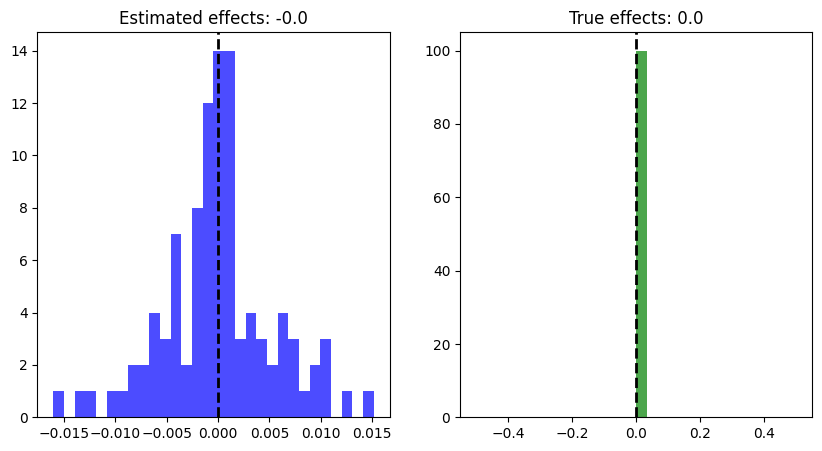

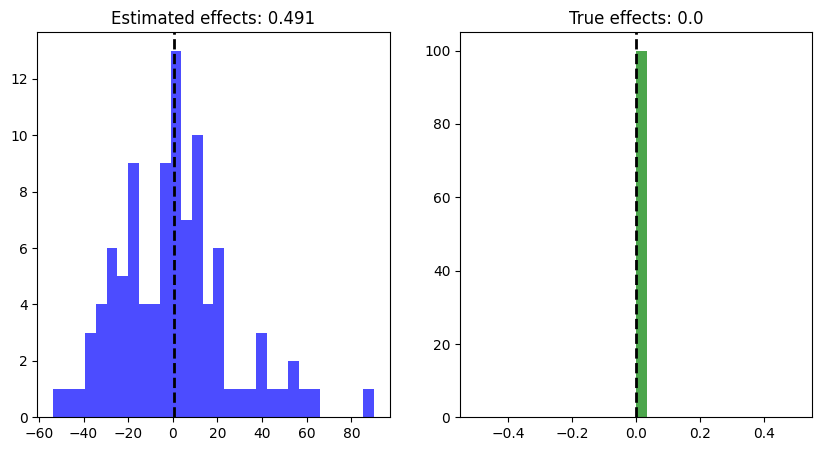

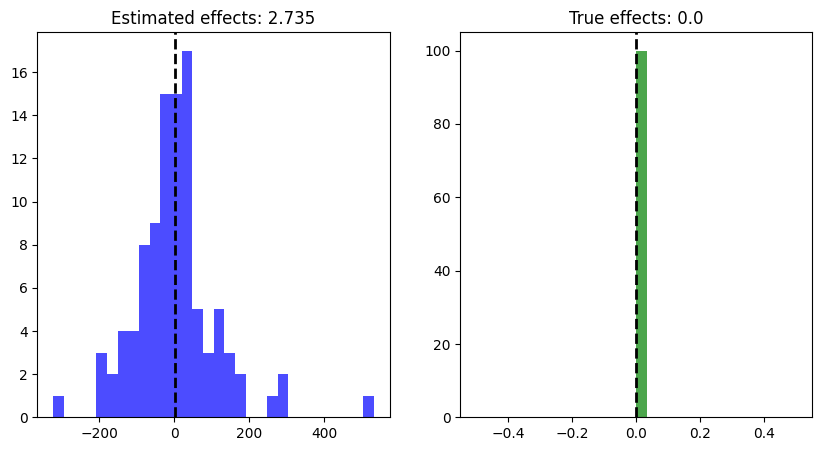

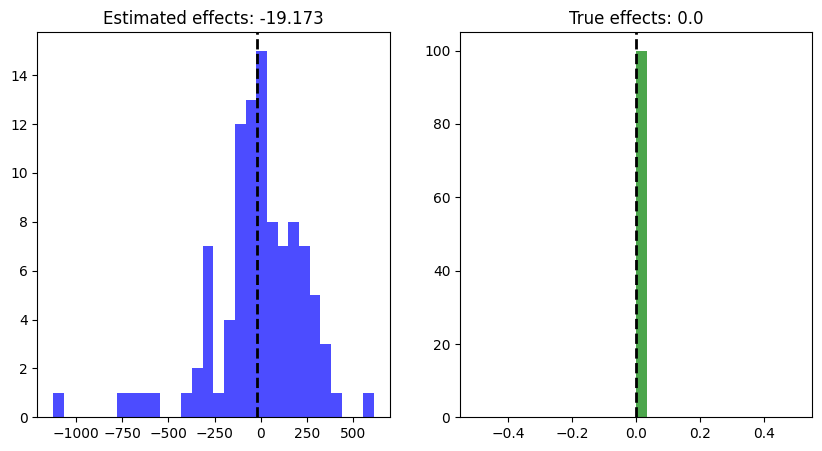

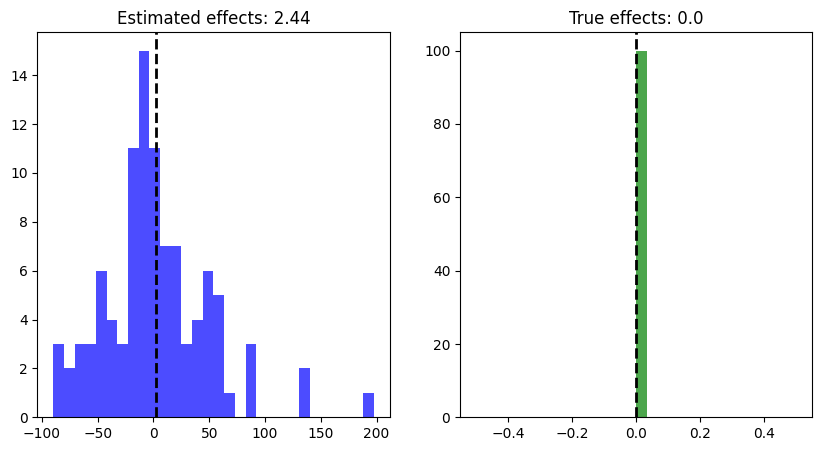

In [29]:
for neighbour_influence in tqdm(n_influence_list):
    outcome_dict, data_dict, betas_dict, group_assignments, true_effects, params, pvalues = simulate_test(
        n_sim=N_SIM,
        n_nodes=N_NODES, 
        n_edges=N_EDGES,
        n_features=N_FEATURES,
        mean_range_cov=MEAN_RANGE,
        std_range_cov = STD_RANGE,
        mean_range_error = MEAN_ERROR_RANGE,
        std_range_error = STD_ERROR_RANGE,
        share_treatment=SHARE_TREATMENT,
        neighbour_influence=neighbour_influence,
        with_effect = False,
        treatment_effect=0,
        seed = seed
    )
    print(f"Simulation results for {neighbour_influence}")
    print("FDR", np.sum(np.array(pvalues) < 0.05) / len(pvalues))
    get_effect_plots(params=params, data_true=true_effects)
    

In [ ]:
for neighbour_influence in tqdm(n_influence_list):
    outcome_dict, data_dict, group_assignments, true_effects, params, pvalues = simulate_test(
        n_sim=N_SIM,
        n_nodes=N_NODES, 
        n_edges=N_EDGES,
        n_features=N_FEATURES,
        mean_range_cov=MEAN_RANGE,
        std_range_cov = STD_RANGE,
        mean_range_error = MEAN_ERROR_RANGE,
        std_range_error = STD_ERROR_RANGE,
        share_treatment=SHARE_TREATMENT,
        neighbour_influence=neighbour_influence,
        with_effect = True,
        treatment_effect=treatment_effect
        seed = seed
    )
    print(f"Simulation results for {neighbour_influence}")
    print("FDR", np.sum(np.array(pvalues) < 0.05) / len(pvalues))
    get_effect_plots(params=params, data_true=true_effects)